In [1]:
# 1. Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from urllib.request import urlopen

In [2]:
# 2. Load the data
url = "https://faculty.chicagobooth.edu/-/media/faculty/ruey-s-tsay/teaching/fts3/m-ibm3dx2608.txt"
# The R code uses Excel, but this is a text file. We'll load it accordingly.
data = pd.read_csv(url, delim_whitespace=True)

# Inspect the first rows
print(data.shape)
print(data.head(1))

/tmp/ipython-input-337852044.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(url, delim_whitespace=True)


(996, 5)
       date    ibmrtn     vwrtn     ewrtn     sprtn
0  19260130 -0.010381  0.000724  0.023174  0.022472


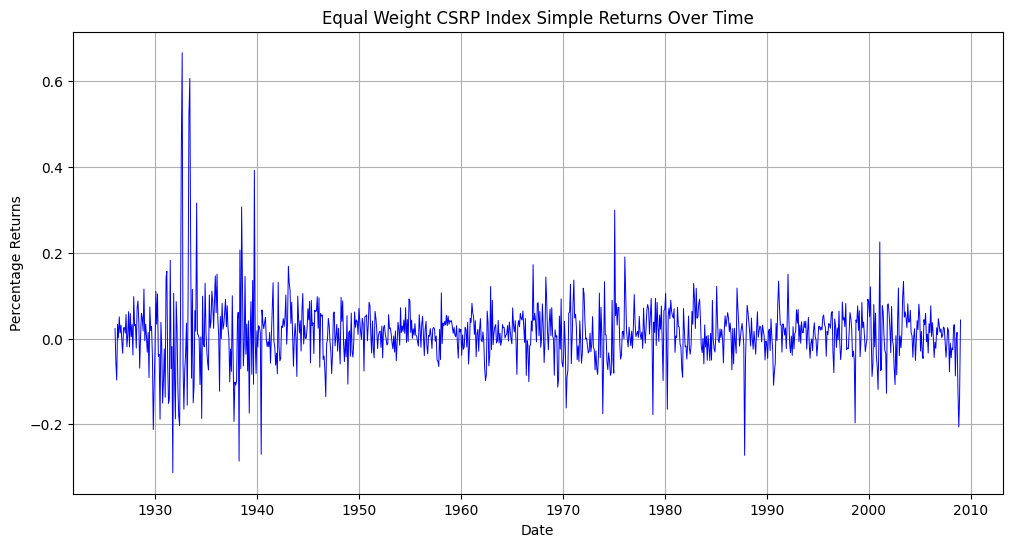

In [3]:
# 3. Convert the date column to datetime
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d')

# 4. Extract the Equal Weight CSRP Index Simple Returns (4th column in R code)
ew = data.iloc[:, 3]

# 5. Time series plot
plt.figure(figsize=(12, 6))
plt.plot(data['date'], ew, color='blue', linewidth=0.7)
plt.title("Equal Weight CSRP Index Simple Returns Over Time")
plt.xlabel("Date")
plt.ylabel("Percentage Returns")
plt.grid(True)
plt.show()

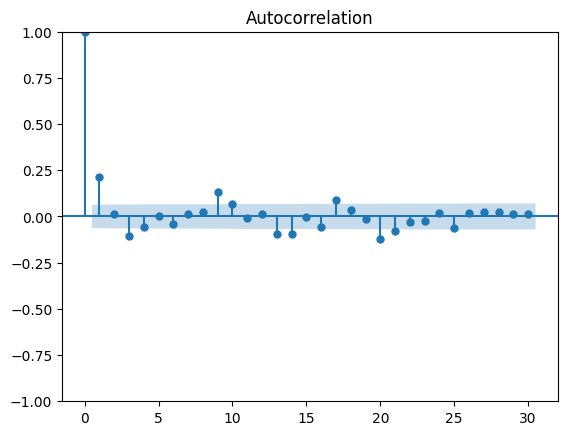

In [5]:
# 6. ACF plot to identify MA order
plot_acf(ew, lags=30)
plt.show()

In [7]:
# 7. Forecast (ARIMA with MA(9) as in R code)
forecast_origin = 986
train = ew[:forecast_origin]

In [8]:
# ARIMA(0,0,9) with some coefficients fixed like R's `fixed`
# Python's ARIMA doesn't directly allow fixed coefficients easily, so we fit a standard MA(9)
ma_model = ARIMA(train, order=(0, 0, 9)).fit()
print(ma_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  ewrtn   No. Observations:                  986
Model:                 ARIMA(0, 0, 9)   Log Likelihood                1211.602
Date:                Sat, 27 Sep 2025   AIC                          -2401.203
Time:                        11:29:02   BIC                          -2347.373
Sample:                             0   HQIC                         -2380.730
                                - 986                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0128      0.003      4.239      0.000       0.007       0.019
ma.L1          0.2075      0.018     11.415      0.000       0.172       0.243
ma.L2          0.0367      0.022      1.682      0.0

In [9]:
# 8. Forecast 10 steps ahead
forecast_steps = 10
forecast_result = ma_model.get_forecast(steps=forecast_steps)
forecast_values = forecast_result.predicted_mean
forecast_se = forecast_result.se_mean

In [11]:
# Actual values for comparison
actual_values = ew[forecast_origin:forecast_origin + forecast_steps].values

In [13]:
# 9. Combine into a DataFrame
df_forecast = pd.DataFrame({
    "Step": np.arange(1, forecast_steps + 1),
    "Forecast": forecast_values.round(4),
    "Std. Error": forecast_se.round(4),
    "Actual": actual_values.round(4)
})

# Display the table
print(df_forecast.to_string(index=False))

 Step  Forecast  Std. Error  Actual
    1    0.0054      0.0708 -0.0260
    2    0.0110      0.0723  0.0312
    3    0.0196      0.0723  0.0322
    4    0.0113      0.0728 -0.0871
    5    0.0159      0.0729 -0.0010
    6   -0.0011      0.0729  0.0141
    7    0.0129      0.0730 -0.1209
    8    0.0064      0.0730 -0.2060
    9    0.0082      0.0731 -0.1366
   10    0.0128      0.0737  0.0431
